In [3]:
import os
import pandas as pd
import numpy as np

In [4]:
from scienceie_loader import load_tokenized_data, load_data_with_char_offsets, get_entity_span_from_B_index

In [5]:
from sklearn.metrics import f1_score, confusion_matrix

import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [6]:
data_root = os.path.join(os.getcwd(), 'original_datasets')
data_train = os.path.join(data_root, 'scienceie2017_train/train2')
data_dev = os.path.join(data_root, 'scienceie2017_dev/dev')
data_test = os.path.join(data_root, 'semeval_articles_test')

In [7]:
train_docs, train_rels, _ = load_tokenized_data(data_train)
#dev_docs, dev_rels, _ = load_tokenized_data(data_dev)
test_docs, test_rels, _ = load_tokenized_data(data_test)

In [8]:
import reader
import nltk
nltk.download("punkt")

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [9]:
tags_names = []
for i in range(len(train_docs)):
    for j in range(len(train_docs[i])):
        tags_names.append(train_docs[i][j][1])

In [10]:
tags_names

['O',
 'B-Task',
 'I-Task',
 'I-Task',
 'I-Task',
 'I-Task',
 'O',
 'O',
 'O',
 'O',
 'B-Material',
 'I-Material',
 'I-Material',
 'O',
 'B-Material',
 'O',
 'O',
 'O',
 'O',
 'O',
 'B-Process',
 'I-Process',
 'I-Process',
 'O',
 'O',
 'O',
 'O',
 'O',
 'B-Task',
 'I-Task',
 'I-Task',
 'I-Task',
 'I-Task',
 'I-Task',
 'O',
 'O',
 'O',
 'B-Process',
 'I-Process',
 'I-Process',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'B-Process',
 'I-Process',
 'O',
 'O',
 'B-Process',
 'I-Process',
 'I-Process',
 'O',
 'B-Process',
 'I-Process',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'B-Process',
 'I-Process',
 'I-Process',
 'O',
 'B-Process',
 'I-Process',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'B-Process',
 'I-Process',
 'I-Process',
 'O',
 'O',
 'B-Process',
 'I-Process',
 'I-Process',
 'O',
 'O',
 'O',
 'O',
 'B-Process',
 'I-Process',
 'I-Process',
 'O',
 'O',
 'O',
 'O',
 'B-Process',
 'I-Process',
 'O',
 'O',
 'O',
 'B-Process',
 'I-Process',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'B-Material'

In [11]:
tag_idx_to_names = np.array(np.unique(tags_names))

In [12]:
type(tag_idx_to_names[0])

numpy.str_

In [13]:
def get_source_target_toks(relation, sentences, tags, sentence_idx):
    sentence = sentences[sentence_idx]
    source = [sentence[relation[1]]]
    next_tok = 2
    while len(tags[sentence_idx]) > relation[1]+next_tok and tags[sentence_idx][relation[1]+next_tok] > 15:  # this means it's an I tag
        source.append(sentence[relation[1]+next_tok])
        next_tok += 1

    target = [sentence[relation[2]]]
    next_tok = 2
    while len(tags[sentence_idx]) > relation[2]+next_tok and tags[sentence_idx][relation[2]+next_tok] > 15:  # this means it's an I tag
        target.append(sentence[relation[2]+next_tok])
        next_tok += 1

    return source, target

In [14]:
counter = 0
nonzero = 0

In [15]:
tag_names_to_idx = {}
for idx, name in enumerate(tag_idx_to_names):
    tag_names_to_idx[name] = idx

In [16]:
sentences = [[tok for tok, lab in sent] for sent in train_docs]
tags = [[tag_names_to_idx[lab] for tok, lab in sent] for sent in train_docs]

In [17]:
train_rels

[[('Synonym-of', 10, 14)],
 [],
 [('Hyponym-of', 10, 6)],
 [('Hyponym-of', 84, 80), ('Hyponym-of', 87, 80), ('Hyponym-of', 92, 80)],
 [('Synonym-of', 56, 58), ('Hyponym-of', 56, 52), ('Hyponym-of', 141, 145)],
 [('Synonym-of', 47, 55), ('Hyponym-of', 126, 122)],
 [],
 [('Hyponym-of', 13, 3)],
 [],
 [],
 [],
 [('Synonym-of', 60, 54)],
 [],
 [('Hyponym-of', 141, 129)],
 [],
 [],
 [],
 [],
 [],
 [('Hyponym-of', 60, 50)],
 [],
 [],
 [],
 [('Synonym-of', 12, 16),
  ('Synonym-of', 19, 23),
  ('Synonym-of', 26, 30),
  ('Synonym-of', 33, 37)],
 [('Hyponym-of', 28, 25), ('Hyponym-of', 37, 32)],
 [('Hyponym-of', 7, 0)],
 [],
 [('Hyponym-of', 90, 140),
  ('Hyponym-of', 101, 140),
  ('Hyponym-of', 112, 140),
  ('Hyponym-of', 118, 140),
  ('Hyponym-of', 131, 140)],
 [('Hyponym-of', 11, 19)],
 [('Hyponym-of', 0, 7), ('Hyponym-of', 0, 18)],
 [('Hyponym-of', 49, 45),
  ('Hyponym-of', 103, 99),
  ('Synonym-of', 142, 146),
  ('Hyponym-of', 142, 118),
  ('Synonym-of', 133, 136),
  ('Hyponym-of', 133, 118

In [18]:
for s, sentence_rels in enumerate(train_rels):
    for relation in sentence_rels: 
        source, target = get_source_target_toks(relation, sentences, tags, s)
        
        print(f"{source} -----> {relation[0]} -----> {target}")
        
        counter += 1
        if relation[2] != 'none':
            nonzero += 1

['continuous'] -----> Synonym-of -----> ['CSTR']
['non-ferromagnetic'] -----> Hyponym-of -----> ['paramagnetic']
['lump'] -----> Hyponym-of -----> ['recover']
['generation'] -----> Hyponym-of -----> ['recover']
['energy'] -----> Hyponym-of -----> ['recover']
['ISAT'] -----> Synonym-of -----> ['In']
['ISAT'] -----> Hyponym-of -----> ['tabulation']
['current'] -----> Hyponym-of -----> ['modification']
['confidentiality'] -----> Synonym-of -----> ['CIRC']
['virtual'] -----> Hyponym-of -----> ['DepSky']
['new'] -----> Hyponym-of -----> ['network']
['semiclathrate'] -----> Synonym-of -----> ['ionic']
['W'] -----> Hyponym-of -----> ['constituents']
['set'] -----> Hyponym-of -----> ['establish']
['Least'] -----> Synonym-of -----> ['LMS']
['Sample'] -----> Synonym-of -----> ['SMI']
['Recursive'] -----> Synonym-of -----> ['RLS']
['Conjugate'] -----> Synonym-of -----> ['CGM']
['clone'] -----> Hyponym-of -----> ['Pseudo-nitzschia']
['clone'] -----> Hyponym-of -----> ['golden']
['eye'] -----> Hypo

In [19]:
print(f"Total number of Pairs : {counter}")
print(f"Positive Examples : {nonzero}")

Total number of Pairs : 680
Positive Examples : 680


In [20]:
path_java = "bin/java"                   #change according to your java file
os.environ['JAVAHOME'] = path_java       
path_gs = "/gs9.53.3/bin"
os.environ['PATH'] = path_gs

In [21]:
from nltk.parse.corenlp import CoreNLPServer, CoreNLPParser
from nltk.parse.corenlp import CoreNLPDependencyParser

In [22]:
STANFORD = "stanford-corenlp-4.2.2/stanford-corenlp-4.2.2/"

In [23]:
server = CoreNLPServer(
   os.path.join(STANFORD, "stanford-corenlp-4.2.2.jar"),
   os.path.join(STANFORD, "stanford-corenlp-4.2.2-models.jar")
   )

In [24]:
server.start()
print("Working")

Working


In [27]:
#This code is taken from Lab6

def extract_relation_BoW(sent_index, rel_index, relations, sentences, tags):
    features = {}
    try:
        relation = relations[sent_index][rel_index]
    except:
        print(relations[sent_index])
        print(sent_index)
        print(rel_index)

    source, target = get_source_target_toks(relation, sentences, tags, sent_index)
    features['source_entity'] = "_".join(source)
    features['target_entity'] = "_".join(target)
    
    pos_tagged_sent = nltk.pos_tag(sentences[sent_index])
    features['source_pos'] = pos_tagged_sent[relation[1]][1]
    features['target_pos'] = pos_tagged_sent[relation[2]][1]
    
    sent = " ".join(sentences[sent_index])
    sent = sent.replace('%', 'percent')
    parsed = False
    while not parsed:
        try:
            parse_tree = [tree for tree in dep_parser.raw_parse(sent)][0]
            parsed = True
        except Exception as e:
            print(sent)
            print(e)
            server.stop()
            server.start()
        
        
    # traverse up the tree
    nodes_on_path0 = []
    current_node = parse_tree.nodes[relation[1] + 1]
    while current_node['address'] != relation[2] + 1 and current_node['head'] is not None:
        current_node = parse_tree.nodes[current_node['head']]
        nodes_on_path0.append(current_node['address'])
    
    # and up from the other side    
    # traverse up the tree
    nodes_on_path1 = []
    current_node = parse_tree.nodes[relation[2] + 1]
    while current_node['address'] != relation[1] + 1 and current_node['head'] is not None:
        current_node = parse_tree.nodes[current_node['head']]   
        nodes_on_path1.append(current_node['address'])
        
    join_node_i = len(nodes_on_path0) - 1
    join_node_j = len(nodes_on_path1) - 1
    for i, node in enumerate(nodes_on_path0):
        if node in nodes_on_path1:
            join_node_i = i
            join_node_j = np.argwhere(np.array(nodes_on_path1) == node).flatten()[0]
            break
    
    dep_path_source = []
    for node in nodes_on_path0[:join_node_i]:
        dep_path_source.append(parse_tree.nodes[node]['rel'])
        
    features['dep_path_source'] = "_".join(dep_path_source)
        
    dep_path_target = []
    for node in nodes_on_path1[:join_node_j]:
        dep_path_target.append(parse_tree.nodes[node]['rel'])
        
    features['dep_path_target'] = "_".join(dep_path_target)
    
    features['dep_path_length'] = join_node_i + join_node_j  # length of dependency path
    
    label = relation[0]  # the class of the relation. 'none' is a negative example of unrelated entities.
    return features, label
    
tag_names_to_idx = {}
for idx, name in enumerate(tag_idx_to_names):
    tag_names_to_idx[name] = idx
    
train_sentences = [[tok for tok, lab in sent] for sent in train_docs]
train_tags = [[tag_names_to_idx[lab] for tok, lab in sent] for sent in train_docs]

features = extract_relation_BoW(3,0, train_rels, train_sentences, train_tags)    


print("---------------------------------")
print("Features")
print(features)
print("---------------------------------")

---------------------------------
Features
({'source_entity': 'Sentence', 'target_entity': 'text', 'source_pos': 'NN', 'target_pos': 'JJ', 'dep_path_source': 'nsubj', 'dep_path_target': 'nmod_nmod', 'dep_path_length': 3}, 'Hyponym-of')
---------------------------------


In [26]:
features = ({'source_entity': 'Sentence', 'target_entity': 'text', 'source_pos': 'NN', 'target_pos': 'JJ', 'dep_path_source': 'nsubj', 'dep_path_target': 'nmod_nmod', 'dep_path_length': 3}, 'Hyponym-of')

In [28]:
def get_features_for_relations(rels, sentences, tags):
    rels_with_feats = []
    for s in range(len(rels)):
        if s % 100 == 0:
            print(s)
        for r in range(len(rels[s])):
            rel_feats, label = extract_relation_BoW(s, r, rels, sentences, tags)
            rels_with_feats.append((rel_feats, label))
    
    return rels_with_feats

In [31]:
train_set_rels = get_features_for_relations(train_rels, train_sentences, train_tags)

0
100
200
300


In [32]:
classifier = nltk.NaiveBayesClassifier.train(train_set_rels)

In [33]:
test_sentences = [[tok for tok, lab in sent] for sent in test_docs]
test_tags = [[tag_names_to_idx[lab] for tok, lab in sent] for sent in test_docs]

In [34]:
f1_score(gold_labels, predicted_labels, average = 'macro')

0.724375


In [35]:
f1_score(gold_labels, predicted_labels, average = None)

array([0.71875, 0.73])


<AxesSubplot:>

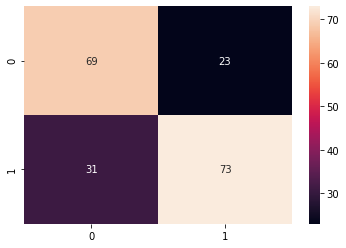

In [ ]:
sn.heatmap(confusion_matrix(gold_labels, predicted_labels), annot=True)